# Idea 4: Samples fitering - online

## Περιγραφή του αλγορίθμου
- Γίνεται εκπαίδευση με grokfast - EMA. Όταν **appl_sampl_filter** is False έχω μόνο αυτό, ενώ για True εφαρμόζω επιπλέον και την ιδέα 4 για πιο έξυπνη επιλογή δειγμάτων.
- Ο Dataloader έχει έναν custom sampler (WeightedRandomSampler) ο οποίος κάθε φορά διαλέγει ένα δείγμα με βάση κάποιο βάρος/πιθανότητα.
- Στην αρχή τα βάρη είναι όλα ίδια (ομοιόμορφη κατανομή) οπότε ο Dataloader λειτουργεί όπως συνήθως διαλέγοντας τυχαία ένα sample.
- Σε κάθε επανάληψη φτιάχνεται ένα ranking των δειγμάτων (με βάση του πόσο high frequency περιέχει το καθένα) το οποίο χρησιμοποιείται για να αποφασιστεί τι βάρος/πιθανότητα θα δοθεί σε κάθε δείγμα να επιλεγεί για εκπαίδευση. Το διάνυσμα βαρών/πιθανοτήτων ανανεώνεται κάθε **sampling_distr_upd_freq** επαναλήψεις.
- Στην κατασκευή του διανύσματος βαρών από την συνολική πιθανότητα 1 δίνουμε στα **top_k** δείγματα συνολικά **top_k_sampling_prob** (και στα υπόλοιπα length(dataset) - **top_k** δείγματα δίνουμε συνολικά το υπόλοιπο 1 - **top_k_sampling_prob**).
- Με **high_freq_better** is True ακολουθούμε την αρχική μας υπόθεση ότι τα δείγματα με high frequency είναι αυτά που θα πρέπει να ταΐσουμε το δίκτυο περισσότερο για να μάθει γρηγορότερα, για False γίνεται το αντίθετο.

## Οδηγίες χρήσης για τρέξιμο
Πήγαινε στον τίτλο **Execute training (by running main funciton)**. Πήγαινε στο parser.parse_args και όρισε τις τιμές που θες να δοκιμάσεις για grid search. Οι υπερπαράμετροι που σχετίζονται με την ιδέα 4 online είναι:

- **top_k**
- **top_k_sampling_prob**
- **high_freq_better**
- **sampling_distr_upd_freq**: Μάλλον είναι οκ στο 1 γιατί ακόμα και έτσι η εκπαίδευση δεν είναι αργή οπότε δεν έχω λόγο να το αυξήσω.

Αν κάποιος θέλει να τρέξει κάποιες τιμές για το grid search, έχω βάλει στον φάκελο και ένα αρχείο για να σημειώνουμε τις τιμές των υπερπαραμέτρων που δοκίμασε ο καθένας για να μην τρέχουμε όλοι τα ίδια. Βάλτε GPU P100 (νομίζω είναι ελαφρώς καλύτερη), εμένα για τα 100.000 βήματα που έχω βάλει να είναι το default ένα τρέξιμο που κάνω μόνο με grokfast (δηλαδή **appl_sampl_filter** is False) παίρνει περίπου **7 λεπτά** οπότε καλά είμαστε από χρόνο.



In [1]:
import kagglehub

# Maybe this is needed if you want to import private datasets
# kagglehub.login()


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

# hojjatk_mnist_dataset_path = kagglehub.dataset_download("hojjatk/mnist-dataset")

# The dataset was uploaded from me but I made it public so you too can probably load it with this line
# _ = kagglehub.dataset_download("konstantinosbarkas/mnist-dataset-processed-from-local")

# print("Data source import complete.")


In [3]:
import sys, os
# Install the Grokfast library
!wget https://raw.githubusercontent.com/ironjr/grokfast/main/grokfast.py

sys.path.append("/kaggle/working")
os.makedirs('/kaggle/working/results/algo_online', exist_ok=True)


--2025-02-12 04:01:08--  https://raw.githubusercontent.com/ironjr/grokfast/main/grokfast.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1703 (1.7K) [text/plain]
Saving to: ‘grokfast.py’

grokfast.py         100%[===================>]   1.66K  --.-KB/s    in 0s      

2025-02-12 04:01:08 (30.9 MB/s) - ‘grokfast.py’ saved [1703/1703]



In [4]:
# import argparse
# import gzip
import math
import random
# import struct
import time
from argparse import ArgumentParser
# from collections import Counter, defaultdict, deque
import itertools
from itertools import islice
# from pathlib import Path
# from typing import Dict, List, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from functorch import grad, vmap
from sklearn.model_selection import train_test_split
from torch.autograd import grad

# from torch.nn.utils.stateless import functional_call, # This is deprecated, use the next one instead
from torch.func import functional_call
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler, Dataset
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from itertools import islice
import torch.nn.functional as F

from grokfast import gradfilter_ema,gradfilter_ma


In [5]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Enables detailed CUDA error messages

results_dir = "/kaggle/working/results/algo_online"
os.makedirs(results_dir, exist_ok=True)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
optimizer_dict = {"AdamW": torch.optim.AdamW, "Adam": torch.optim.Adam, "SGD": torch.optim.SGD}

activation_dict = {"ReLU": nn.ReLU, "Tanh": nn.Tanh, "Sigmoid": nn.Sigmoid, "GELU": nn.GELU}

loss_function_dict = {"MSE": nn.MSELoss, "CrossEntropy": nn.CrossEntropyLoss}


In [8]:
class Block(nn.Module):
    """Causal transformer block
    """

    def __init__(self, dim, num_heads):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.ln_2 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
        )

    def forward(self, x):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)
        attn_mask[torch.isnan(attn_mask)] = 0.0 # fixes all 'nan' on 'mps' device

        x = self.ln_1(x)
        a, _ = self.attn(x, x, x, attn_mask=attn_mask, need_weights=False)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x


In [9]:
class Decoder(nn.Module):
    """Causal Transformer decoder
    """

    def __init__(self, dim=128, num_layers=2, num_heads=4, num_tokens=97, seq_len=5):
        super().__init__()
        self.token_embeddings = nn.Embedding(num_tokens, dim)
        self.position_embeddings = nn.Embedding(seq_len, dim)
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(Block(dim, num_heads))

        self.ln_f = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_tokens, bias=False)

    def forward(self, x):
        # Ensure input tensor x contains valid token IDs
        x = torch.clamp(x, 0, self.token_embeddings.num_embeddings - 1)

        h = self.token_embeddings(x)
        positions = torch.arange(x.shape[0], device=x.device).unsqueeze(-1)
        positions = torch.clamp(positions, 0, self.position_embeddings.num_embeddings - 1)

        h = h + self.position_embeddings(positions).expand_as(h)
        for layer in self.layers:
            h = layer(h)

        h = self.ln_f(h)
        logits = self.head(h)
        return logits


In [10]:
def multiplication_mod_p_data(p, eq_token, op_token):
    """x◦y = x/y (mod p) for 0 ≤ x < p, 0 < y < p
    """
    x = torch.arange(p)
    y = torch.arange(1, p)
    x, y = torch.cartesian_prod(x, y).T

    eq = torch.ones_like(x) * eq_token
    op = torch.ones_like(x) * op_token
    result = x * y % p

    return torch.stack([x, op, y, eq, result])


In [11]:
# def cycle(iterable):
#     while True:
#         for x in iterable:
#             yield x


In [12]:
# # Not used anymore
# def custom_collate_fn_2(batch):
#     """Custom collate function to handle extra fields in the dataset."""
#     images, labels, _, _ = zip(*batch)  # Ignore the indices and extra_fields for loss computation
#     images = torch.stack(images)  # Stack images into a single tensor
#     labels = torch.tensor(labels)  # Convert labels to a tensor
#     return images, labels


In [13]:
def custom_collate_fn(batch):
    samples, labels, indices, extra_fields = zip(*batch)
    samples = torch.stack(samples)  # Stack samples into a single tensor
    labels = torch.tensor(labels)  # Convert labels to a tensor

    return samples, labels, indices, extra_fields


In [14]:
# Needed for per sample gradient computations
def select_random_subset(tensor, percentage, seed=42):
    """
    Flatten the parameter dimensions for each batch sample, select a percentage of elements,
    and return a tensor with shape [batch_size, selected_elements].

    Args:
        tensor (torch.Tensor): The gradient tensor of shape [batch_size, *parameter_dims].
        percentage (float): The percentage of elements to select.
        seed (int): Random seed for reproducibility.

    Returns:
        torch.Tensor: A tensor of shape [batch_size, selected_elements].
    """
    batch_size, *param_dims = tensor.shape  # Extract batch and parameter dimensions
    total_params = torch.prod(torch.tensor(param_dims))  # Total parameters per sample
    subset_size = int(total_params * percentage)  # 20% of parameters

    # Set seed for reproducibility
    random.seed(seed)
    indices = random.sample(range(total_params), subset_size)  # Random indices for selection

    # Flatten parameter dimensions and select elements for each batch
    flat_tensor = tensor.view(batch_size, -1)  # Flatten parameter dimensions for each sample
    selected_subset = flat_tensor[:, indices]  # Select the same random indices across the batch

    return selected_subset


In [15]:
# Needed for online sample filtering
def rank_to_sampling_weights(my_dataset, top_k, top_k_sampling_prob, high_freq_better):
    """
    Rank samples by variance_metric and assign sampling weights.

    Parameters:
    - my_dataset: MyMNIST object.
    - top_k: Fraction of top samples to assign higher sampling probability.
    - top_k_sampling_prob: Probability assigned to the top_k fraction of samples.

    Returns:
    - new_weights: List of sampling weights for each sample.
    """
    # Calculate the number of top_k samples
    num_samples = len(my_dataset)
    top_k_count = int(top_k * num_samples)

    # Sort indices by variance_metric in descending order
    sorted_indices = sorted(
        range(num_samples),
        key=lambda idx: my_dataset.dataset.extra_fields[idx]["variance_metric"],
        reverse=high_freq_better,
    )

    # Initialize new_weights with zeros
    new_weights = [0.0] * num_samples

    # Assign weights to the top_k samples
    for idx in sorted_indices[:top_k_count]:
        new_weights[idx] = top_k_sampling_prob / top_k_count

    # Assign weights to the rest of the samples
    for idx in sorted_indices[top_k_count:]:
        new_weights[idx] = (1 - top_k_sampling_prob) / (num_samples - top_k_count)

    return new_weights


In [16]:
class AlgoDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        """
        Custom dataset to store dataset + extra fields for each sample.
        Insert data as a tensor of shape [num_samples, num_features] and targets as a tensor of shape [num_samples].
        """

        self.data = data
        self.targets = targets

        # Initialize extra fields
        self.extra_fields = [
            {
                "ema_grad": 0.0,
                "num_updates": 0,
                "variance_metric": 0.0,
            }
            for _ in range(len(self.data))
        ]

    def __getitem__(self, index):
        """Returns a single data sample with extra fields."""

        sample, target = self.data[index], self.targets[index]

        extra_field = self.extra_fields[index]
        return sample, target, int(index), extra_field

    def __len__(self):
        return len(self.data)

    def update_fields(self, indices, grad_stats, ema_alpha=0.9):
        """
        Update the extra fields for specified dataset indices.
        """

        for idx, grad in zip(indices, grad_stats):
            # Update EMA
            sample_field = self.extra_fields[idx]

            current_ema = sample_field["ema_grad"]
            updated_ema = ema_alpha * current_ema + (1 - ema_alpha) * grad
            sample_field["ema_grad"] = updated_ema

            deviation = abs(grad - current_ema)

            num_updates = sample_field["num_updates"] + 1  # Increment the update count

            current_avg_deviation = sample_field["variance_metric"] ** 0.5
            new_avg_deviation = ((current_avg_deviation * (num_updates - 1)) + deviation) / num_updates

            sample_field["num_updates"] = num_updates

            # Variance estimate (for higher sensitivity to fast changes)
            sample_field["variance_metric"] = new_avg_deviation**2


## def main

In [17]:
def main(args):
    torch.manual_seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    eq_token = args.p
    op_token = args.p + 1

    # Create model
    model = Decoder(
        dim=128, num_layers=2, num_heads=4, num_tokens=args.p + 2, seq_len=5
    ).to(device)
    print(model)
    nparams = sum([p.numel() for p in model.parameters() if p.requires_grad])
    print(f'Total number of parameters: {nparams}')

    # Create dataset
    data = multiplication_mod_p_data(args.p, eq_token, op_token)
    # data = data.T

    # Split the dataset into training and validation sets
    train_idx, valid_idx = torch.randperm(data.shape[1]).split(data.shape[1] // 2)
    train_data, valid_data = data[:, train_idx], data[:, valid_idx]

    # Create initial weights for uniform sampling
    weights = [1.0] * len(train_data)
    sampler = WeightedRandomSampler(weights, len(weights))

    # DataLoader
    train_dataset = AlgoDataset(train_data[:4].T, train_data[4])
    valid_dataset = AlgoDataset(valid_data[:4].T, valid_data[4])

    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, sampler=sampler, collate_fn=custom_collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=args.batch_size, collate_fn=custom_collate_fn)

    # data_iter = cycle(train_loader)

    # Optimizer
    optimizer = getattr(torch.optim, args.optimizer)(
        model.parameters(),
        lr=args.lr,
        weight_decay=args.weight_decay,
        betas=(args.beta1, args.beta2),
    )

    # Scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, lambda update: 1 if update > 10 else update / 10
    )

    steps_per_epoch = math.ceil(data.shape[1] / args.batch_size)

    # ----------------------------------------------------------------------------------
    # # Needed for per sample gradient computations
    # if args.appl_sampl_filter:
    #     # Define a function for forward + loss computation
    #     def compute_loss_vmap(params, buffers, model, x, y):
    #         logits = functional_call(model, {**params, **buffers}, x.unsqueeze(0))
    #         loss = loss_fn(logits, y.unsqueeze(0))  # Single output
    #         return loss.mean()

    #     # Prepare model parameters and buffers
    #     params_and_buffers = {**dict(model.named_parameters()), **dict(model.named_buffers())}

    #     params = {k: v for k, v in params_and_buffers.items() if v.requires_grad}
    #     buffers = {k: v for k, v in params_and_buffers.items() if not v.requires_grad}

    #     # Create the gradient function
    #     gradient_fn = grad(compute_loss_vmap)
    # ----------------------------------------------------------------------------------

    # Start Training below
    its, train_acc, val_acc, train_loss, val_loss = [], [], [], [], []
    grads = None
    i = 0

    # For logging network weights.
    net_its, nets = [], []

    optim_steps = int(args.budget) // steps_per_epoch
    log_tqdm_freq = math.ceil(optim_steps / 150)

    with tqdm(total=(optim_steps), dynamic_ncols=True) as pbar:

        stable_steps = 0
        stable_threshold = 1000
        reached_early_stop = False
        steps_to_reach_val_acc = None

        for e in range(optim_steps):
            if reached_early_stop: break

            for dataloader, is_train in [(train_dataloader, True), (valid_dataloader, False)]:

                # Update sampling distribution periodically
                if args.appl_sampl_filter and i > args.start and i % args.sampling_distr_upd_freq == 0:
                    new_weights = rank_to_sampling_weights(train_dataset, args.top_k, args.top_k_sampling_prob, args.high_freq_better)
                    new_sampler = WeightedRandomSampler(new_weights, num_samples=len(train_data), replacement=True)
                    train_dataloader = DataLoader(
                        train_data,
                        batch_size=args.batch_size,
                        sampler=new_sampler,
                        collate_fn=custom_collate_fn
                    )

                model.train(is_train)
                total_loss = 0
                total_acc = 0

                for samples, targets, indices, _, in dataloader:

                    samples, targets = samples.to(device), targets.to(device)

                    with torch.set_grad_enabled(is_train):
                        logits = model(samples.T)
                        # calculate loss only on the answer part of the equation (last element
                        loss = F.cross_entropy(logits[-1], targets)
                        total_loss += loss.item() * samples.shape[0]

                        if is_train:
                            optimizer.zero_grad()
                            loss.backward()


                        # if args.appl_sampl_filter:  # Unnecessary if we are not applying sample filtering
                        #     # -----------------------------------------------------------------
                        #     #   Gradient Stats: Capture grads for each sample
                        #     # -----------------------------------------------------------------
                        #     # Identify the last two Linear layers dynamically
                        #     # batch_gradients = []

                        #     with torch.no_grad():
                        #         per_sample_grads = vmap(gradient_fn, in_dims=(None, None, None, 0, 0))(
                        #             params, buffers, mlp, x, labels
                        #         )  # Use torch.vmap


                        #         # Extract gradients for the target layers
                        #         last_layer_grad = per_sample_grads["3.weight"]  # Adjust key as needed
                        #         second_last_layer_grad = per_sample_grads["5.weight"]

                        #         # Select a subset of gradients
                        #         percentage_s_l = 0.2
                        #         percentage_l = 1
                        #         selected_last = select_random_subset(last_layer_grad, percentage_l, seed=42)
                        #         selected_second_last = select_random_subset(second_last_layer_grad, percentage_s_l, seed=42)

                        #         # Compute the average and detach
                        #         selected_last_avg = selected_last.mean(dim=-1).detach().cpu()
                        #         selected_second_last_avg = selected_second_last.mean(dim=-1).detach().cpu()
                        #         total_avg = (selected_last_avg + selected_second_last_avg) / 2

                        #     train_dataset.dataset.update_fields(indices, total_avg, args.ema_alpha_sampl_rank)

                        # # -----------------------------------------------------------------
                        # # -----------------------------------------------------------------


                        #######
                        # Grokfast

                        trigger = i < 500 if args.two_stage else False

                        if args.filter == "none":
                            pass
                        elif args.filter == "ma":
                            grads = gradfilter_ma(model, grads=grads, window_size=args.window_size, lamb=args.lamb, trigger=trigger)
                        elif args.filter == "ema":
                            grads = gradfilter_ema(model, grads=grads, alpha=args.alpha, lamb=args.lamb)
                        else:
                            raise ValueError(f"Invalid gradient filter type `{args.filter}`")

                        #######

                        optimizer.step()
                        scheduler.step()
                        i += 1

                        acc = (logits[-1].argmax(-1) == samples.T).float().mean()
                        total_acc += acc.item() * samples.shape[0]

                    if is_train:
                        train_acc.append(total_acc / len(train_dataset))
                        train_loss.append(total_loss / len(train_dataset))
                        its.append(i)
                    else:
                        val_acc.append(total_acc / len(valid_dataset))
                        val_loss.append(total_loss / len(valid_dataset))

                    do_log_tqdm = (i < 150 and i % 10 == 0) or i % log_tqdm_freq == 0
                    if do_log_tqdm and (not is_train):
                        pbar.set_description(
                        "Loss: {0:1.1e}|{1:1.1e}. Acc: {2:2.1f}%|{3:2.1f}%".format(
                            train_loss[-1],
                            val_loss[-1],
                            train_acc[-1] * 100,
                            val_acc[-1] * 100,))


                    # Early Stopping Logic
                    val_acc_last = val_acc[-1] if len(val_acc) > 0 else 0
                    if val_acc_last >= 0.92 and steps_to_reach_val_acc is None:
                        steps_to_reach_val_acc = i

                    # Check for stable performance
                    if val_acc_last > 0.9:
                        stable_steps += 1
                    else:
                        stable_steps = 0  # Reset counter if accuracy drops below 0.85

                    if stable_steps >= stable_threshold and val_acc_last >= 0.9 and steps_to_reach_val_acc is not None:
                        reached_early_stop = True
                        print(f"Validation accuracy of 0.92 reached and remained > 0.9 for {stable_threshold} steps at step {i}")

            pbar.update(1)

    # Save results
    specific_result_dir = f"algo_{args.label}.pt"
    results_filename = os.path.join(results_dir, specific_result_dir)
    torch.save(
        {
            "its": its,
            "train_acc": train_acc,
            "train_loss": train_loss,
            "val_acc": val_acc,
            "val_loss": val_loss,
            "steps_to_reach": steps_to_reach_val_acc,
            "model_state_dict": model.state_dict(),
        },
        results_filename,
    )
    print(f"Saving to {results_filename}")
    print(f"\nTraining complete!")
    print(f"Steps to reach 0.92 validation accuracy: {steps_to_reach_val_acc}")


In [18]:
# Remove the extra arguments passed by the Jupyter Notebook kernel
sys.argv = [""]


In [19]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def analyze_results(label, results_dir="/kaggle/working/results/algo_online"):
    """
    Loads model results, extracts accuracy/loss data, and generates plots.

    Args:
        label (str): Label identifier for the results file.
        results_dir (str): Directory where results are stored.

    Returns:
        None
    """

    # Define file paths
    filename = f"algo_{label}.pt"  # Adjusted filename format
    results_filename = os.path.join(results_dir, filename)

    filename_plot_acc = f"algo_{label}_acc.png"
    results_filename_plot_acc = os.path.join(results_dir, filename_plot_acc)

    filename_plot_loss = f"algo_{label}_loss.png"
    results_filename_plot_loss = os.path.join(results_dir, filename_plot_loss)

    try:
        # Load results
        results = torch.load(results_filename)  # Removed invalid weights_only=True

        # Extract data
        its = results["its"]  # Optimization steps
        train_acc = results["train_acc"]  # Training accuracy
        val_acc = results["val_acc"]  # Validation accuracy
        train_loss = results["train_loss"]  # Training loss
        val_loss = results["val_loss"]  # Validation loss
        steps_to_reach = results.get("steps_to_reach", None)  # Handle missing key

        if steps_to_reach:
            print(f"Steps needed to reach 0.9 validation accuracy: {steps_to_reach}")

        # Plot Accuracy
        plt.figure()
        plt.plot(its, train_acc, label="Train Accuracy", color="blue")
        plt.plot(its, val_acc, label="Validation Accuracy", color="red")

        # Find and annotate the maximum validation accuracy
        max_val_acc = max(val_acc)
        max_val_idx = val_acc.index(max_val_acc)
        plt.annotate(f"Max Val Acc: {max_val_acc:.4f}",
                     (its[max_val_idx], max_val_acc),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center',
                     fontsize=10,
                     color='red')

        plt.legend()
        plt.title(f"Accuracy - {label}")
        plt.xlabel("Optimization Steps")
        plt.ylabel("Accuracy")
        plt.xscale("log")
        plt.grid()
        if steps_to_reach:
            plt.figtext(0.5, -0.1, f"Steps to reach val=0.9 = {steps_to_reach}",
                        ha="center", fontsize=10, style="italic")

        plt.savefig(results_filename_plot_acc, dpi=150)
        plt.show()
        plt.close()

        print(f"Plots saved successfully at {results_filename_plot_acc}")

    except FileNotFoundError:
        print(f"Error: Results file {results_filename} not found.")
    except Exception as e:
        print(f"Error while processing {label}: {e}")

def plot_all_experiments_together(labels, results_dir="/kaggle/working/results/algo_online", show_only_val=False):
    """
    Plots train and validation accuracy for multiple experiments in a single graph.
    Allows showing only validation accuracy if `show_only_val=True`.

    Args:
        labels (list of str): List of labels corresponding to result files.
        results_dir (str): Directory where results are stored.
        show_only_val (bool): If True, only plots validation accuracy.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))  # Set figure size

    # Generate distinct colors for each experiment
    base_colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

    for i, label in enumerate(labels):
        results_filename = os.path.join(results_dir, f"algo_{label}.pt")

        try:
            # Load results
            results = torch.load(results_filename)
            its = results["its"]
            train_acc = results["train_acc"]
            val_acc = results["val_acc"]
            steps_to_reach = results.get("steps_to_reach", None)  # Handle missing key

            # Assign colors for train and validation curves
            val_color = base_colors[i]  # Primary color for validation
            train_color = tuple(c * 0.7 for c in base_colors[i])  # Slightly darker shade for train

            # Plot validation accuracy (always shown)
            plt.plot(its, val_acc, label=f"Validation ({label})", color=val_color, linestyle="solid")

            if steps_to_reach:
                plt.figtext(0.5, -0.1, f"Steps to reach val=0.9 = {steps_to_reach}",
                            ha="center", fontsize=10, style="italic")

            # Plot train accuracy if `show_only_val` is False
            if not show_only_val:
                plt.plot(its, train_acc, label=f"Train ({label})", color=train_color, linestyle="dashed")

        except FileNotFoundError:
            print(f"Warning: Results file {results_filename} not found.")
        except Exception as e:
            print(f"Error while processing {label}: {e}")

    plt.legend()
    plt.title("Train & Validation Accuracy for Multiple Experiments" if not show_only_val else "Validation Accuracy for Multiple Experiments")
    plt.xlabel("Optimization Steps")
    plt.ylabel("Accuracy")
    plt.xscale("log")
    plt.grid()

    # Save and show the plot
    filename = "combined_train_val_plot.png" if not show_only_val else "combined_val_plot.png"
    plot_path = os.path.join(results_dir, filename)
    plt.savefig(plot_path, dpi=150)
    plt.show()

    print(f"Combined plot saved at {plot_path}")


## Execute training (by running main function)

From now on i just train networks with different configurations every timeand then I print their results after.

### Simple training:

    * no grokfast applied
    * no filtering
    * wd = 0



            

In [20]:
if __name__ == "__main__":
    # Same as used in paper of Grokfast
    parser = ArgumentParser(description="Train a model on Algorithmic Dataset without custom sampling")

    parser.add_argument("--label", type=str, default="")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--p", type=int, default=97)
    parser.add_argument("--budget", type=int, default=3e5)
    parser.add_argument("--batch_size", type=int, default=512)
    parser.add_argument("--optimizer", type=str, default="Adam")
    parser.add_argument("--beta1", type=float, default=0.9)
    parser.add_argument("--beta2", type=float, default=0.98)
    parser.add_argument("--weight_decay", type=float, default=0)
    parser.add_argument("--lr", type=float, default=1e-3)


    # Grokfast
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.99)
    parser.add_argument("--window_size", type=int, default=100)
    parser.add_argument("--lamb", type=float, default=5.0)

    # Ablation studies
    parser.add_argument("--two_stage", action='store_true')
    parser.add_argument("--save_weights", action='store_true')

    # Samples ranking
    parser.add_argument("--ema_alpha_sampl_rank", type=float, default=0.9)

    # Boolean arguements need this due to bad behavior of parser.parse_args
    def boolean_string(s):
        if s not in {"False", "True"}:
            raise ValueError("Not a valid boolean string")
        return s == "True"

    # These are the hyperparameters related to our online sampling filtering algorithm
    parser.add_argument("--appl_sampl_filter", type=boolean_string, default=True)  # If False, perform regular training
    parser.add_argument("--start", type=int, default=1000) # When to start the sample filtering
    parser.add_argument("--sampling_distr_upd_freq", type=int, default=1)  # How often to update the sampling distribution
    parser.add_argument("--top_k", type=float, default=0.1)  # Fraction of samples to select more frequently
    parser.add_argument("--top_k_sampling_prob", type=float, default=0.7)  # Probability of selecting a sample from the top-k
    parser.add_argument("--high_freq_better", type=boolean_string, default=True)  # If True, samples with higher frequency gradient content are considered better for training


    # -----------------------------------------------------------------
    # Try different hyperparameter values for your grid search here
    # -----------------------------------------------------------------
    args = parser.parse_args(
        [
            "--appl_sampl_filter", "False",
            "--sampling_distr_upd_freq", "1",
            "--top_k", "0.1",
            "--top_k_sampling_prob", "0.7",
            "--high_freq_better", "True",
            "--filter", "none",
        ]
    )
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------

    # Create arg.label for the filename of the saved results
    if not args.appl_sampl_filter:
        args.label = f"filter{args.filter}_sampling_{args.appl_sampl_filter}"
    else:
        args.label = f"high_freq_{args.high_freq_better}_top_k_{args.top_k}_top_k_prob_{args.top_k_sampling_prob}_upd_freq_{args.sampling_distr_upd_freq}"

    # Training with time recording

    # Start the timer
    start_time = time.time()

    # Call your training function
    main(args)

    # End the timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to minutes and seconds (optional)
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Training completed in {int(minutes)} minutes and {int(seconds)} seconds.")
    print(f"label:{args.label}")


Decoder(
  (token_embeddings): Embedding(99, 128)
  (position_embeddings): Embedding(5, 128)
  (layers): ModuleList(
    (0-1): 2 x Block(
      (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=99, bias=False)
)
Total number of parameters: 422784


  0%|          | 0/15789 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# results_filename = "/kaggle/working/results/algo_online/algo_filternone_sampling_False.pt" # Not needed because analyze_results has it inside


<ipython-input-199-916eb565f695>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(results_filename)  # Removed invalid weights_only=True


Error while processing filternone_sampling_False: x and y must have same first dimension, but have shapes (15789,) and (157890,)


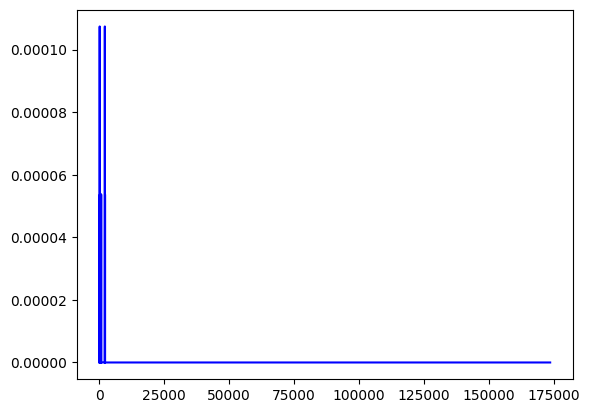

In [202]:
# args.label = "filternone_sampling_False" # Not needed because we already have args.label from above
analyze_results(args.label)


### Only Grokfast
    * grokfast applied
    * no filtering
    * wd = 0

In [ ]:
if __name__ == "__main__":
    # Same as used in paper of Grokfast
    parser = ArgumentParser(description="Train a model on MNIST without custom sampling")

    parser.add_argument("--label", type=str, default="")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--p", type=int, default=97)
    parser.add_argument("--budget", type=int, default=3e5)
    parser.add_argument("--batch_size", type=int, default=512)
    parser.add_argument("--optimizer", type=str, default="Adam")
    parser.add_argument("--beta1", type=float, default=0.9)
    parser.add_argument("--beta2", type=float, default=0.98)
    parser.add_argument("--weight_decay", type=float, default=0)
    parser.add_argument("--lr", type=float, default=1e-3)

    # Grokfast
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="ema")
    parser.add_argument("--alpha", type=float, default=0.8)
    parser.add_argument("--lamb", type=float, default=0.1)

    # Samples ranking
    parser.add_argument("--ema_alpha_sampl_rank", type=float, default=0.9)

    # Boolean arguements need this due to bad behavior of parser.parse_args
    def boolean_string(s):
        if s not in {"False", "True"}:
            raise ValueError("Not a valid boolean string")
        return s == "True"

    # These are the hyperparameters related to our online sampling filtering algorithm
    parser.add_argument("--appl_sampl_filter", type=boolean_string, default=True)  # If False, perform regular training
    parser.add_argument("--start", type=int, default=1000) # When to start the sample filtering
    parser.add_argument("--sampling_distr_upd_freq", type=int, default=1)  # How often to update the sampling distribution
    parser.add_argument("--top_k", type=float, default=0.1)  # Fraction of samples to select more frequently
    parser.add_argument("--top_k_sampling_prob", type=float, default=0.7)  # Probability of selecting a sample from the top-k
    parser.add_argument("--high_freq_better", type=boolean_string, default=True)  # If True, samples with higher frequency gradient content are considered better for training

    # -----------------------------------------------------------------
    # Try different hyperparameter values for your grid search here
    # -----------------------------------------------------------------
    args = parser.parse_args(
        [
            "--appl_sampl_filter", "False",
            "--sampling_distr_upd_freq", "1",
            "--top_k", "0.1",
            "--top_k_sampling_prob", "0.7",
            "--high_freq_better", "True",
        ]
    )
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------

    # Create arg.label for the filename of the saved results
    if not args.appl_sampl_filter:
        args.label = f"filter{args.filter}_sampling_{args.appl_sampl_filter}"
    else:
        args.label = f"high_freq_{args.high_freq_better}_top_k_{args.top_k}_top_k_prob_{args.top_k_sampling_prob}_upd_freq_{args.sampling_distr_upd_freq}"

    # Training with time recording

    # Start the timer
    start_time = time.time()

    # Call your training function
    main(args)

    # End the timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to minutes and seconds (optional)
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Training completed in {int(minutes)} minutes and {int(seconds)} seconds.")
    print(f"label:{args.label}")


In [ ]:
# args.label="filterema_sampling_False" # Not needed because we already have args.label from above
analyze_results(args.label)


### Grid Search

In [ ]:
# Define possible values for each parameter
param_grid = {
    "top_k": [0.2],  # Convert to float
    "top_k_sampling_prob": [0.7],  # Convert to float
    "sampling_distr_upd_freq": [10],  # Convert to int
    "high_freq_better": [True]  # Boolean parameter
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(*param_grid.values()))

# Run main in a loop for each combination
for param_values in param_combinations:
    # Extract parameter values
    top_k = param_values[0]
    top_k_sampling_prob = param_values[1]
    sampling_distr_upd_freq = param_values[2]
    high_freq_better = param_values[3]  # Boolean value

    # Ensure boolean values are correctly formatted as strings for argparse
    high_freq_better_str = "True" if high_freq_better else "False"

    # Create args dynamically
    args_list = [
        "--appl_sampl_filter" , "True",
        "--top_k", str(top_k),
        "--top_k_sampling_prob", str(top_k_sampling_prob),
        "--sampling_distr_upd_freq", str(sampling_distr_upd_freq),
        "--high_freq_better", high_freq_better_str,
        "--label", f"{top_k}_{top_k_sampling_prob}_{sampling_distr_upd_freq}_{high_freq_better}"
    ]

    # Debug print statement
    print(f"\nRunning with parameters: {args_list}")

    # Parse the arguments dynamically
    args = parser.parse_args(args_list)

    # Call main() with the updated args
    main(args)


In [ ]:
#/kaggle/working/results/mnist_online/mnist_high_freq_True_top_k_0.2_top_k_prob_0.9_upd_freq_1.pt
# args.label="high_freq_True_top_k_0.2_top_k_prob_0.9_upd_freq_1" # Not needed because we already have args.label from above
analyze_results(args.label)


### Grid search for high_freq_better=False
no sure if the code is ok

In [ ]:
args_list = [
    "--appl_sampl_filter" , "False",
]

# Parse the arguments dynamically
args = parser.parse_args(args_list)

# Call main() with the updated args
main(args)


In [ ]:
analyze_results(args.label)
